In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Get chord annotation
import autorootcwd
from src.utils import get_raw_chord_annotation, get_filenames, get_raw_beats
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def estimate_bpm(beats):
    """
    Given a list (or np.array) of beat times in seconds, 
    estimate BPM (Beats Per Minute) by computing the average interval between beats.
    
    Returns:
        float: Estimated BPM.
    """
    if len(beats) < 2:
        return 0.0
    
    # Calculate the intervals (in seconds) between consecutive beats
    intervals = np.diff(beats)
    
    # Compute average interval
    avg_interval = np.mean(intervals)
    
    # BPM is 60 / average interval in seconds
    estimated_bpm = 60.0 / avg_interval
    
    return estimated_bpm

In [5]:
dir = './data/processed/beats'

bpms = []
beat_lengths = []

for filename in os.listdir(dir):
    if filename.endswith(".npy"):
        beats = np.load(os.path.join(dir, filename))
    
    bpm = estimate_bpm(beats)
    beat_lengths.extend(np.diff(beats))
    bpms.append(bpm)

In [6]:
mean_bpm = np.mean(bpms)
std_bpm = np.std(bpms)
median_bpm = np.median(bpms)
print(f"Mean BPM: {mean_bpm:.2f}")
print(f"Standard Deviation of BPM: {std_bpm:.2f}")
print(f"Median BPM: {median_bpm:.2f}")

Mean BPM: 117.80
Standard Deviation of BPM: 27.54
Median BPM: 117.80


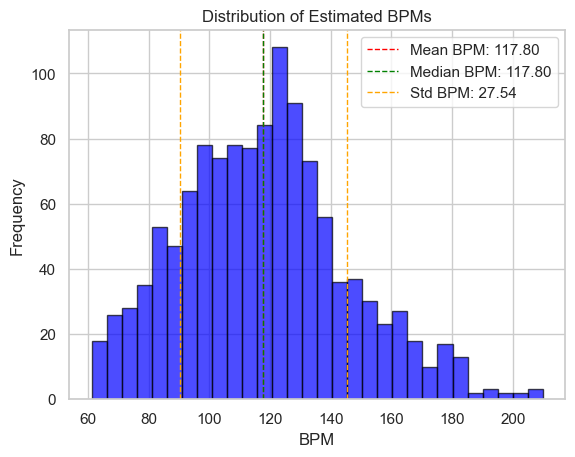

In [7]:
plt.hist(bpms, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Estimated BPMs')
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.axvline(mean_bpm, color='red', linestyle='dashed', linewidth=1, label=f'Mean BPM: {mean_bpm:.2f}')
plt.axvline(median_bpm, color='green', linestyle='dashed', linewidth=1, label=f'Median BPM: {median_bpm:.2f}')
plt.axvline(mean_bpm + std_bpm, color='orange', linestyle='dashed', linewidth=1, label=f'Std BPM: {std_bpm:.2f}')
plt.axvline(mean_bpm - std_bpm, color='orange', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

In [8]:
mean_beat_length = np.mean(beat_lengths)
std_beat_length = np.std(beat_lengths)
median_beat_length = np.median(beat_lengths)
print(f"Mean Beat Length: {mean_beat_length:.2f} seconds")
print(f"Standard Deviation of Beat Length: {std_beat_length:.2f} seconds")
print(f"Median Beat Length: {median_beat_length:.2f} seconds")

Mean Beat Length: 0.52 seconds
Standard Deviation of Beat Length: 0.13 seconds
Median Beat Length: 0.49 seconds


In [9]:
min_beat_length = np.min(beat_lengths)
max_beat_length = np.max(beat_lengths)
print(f"Minimum Beat Length: {min_beat_length:.2f} seconds")
print(f"Maximum Beat Length: {max_beat_length:.2f} seconds")

Minimum Beat Length: 0.27 seconds
Maximum Beat Length: 1.15 seconds


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn theme for a clean, white-grid background
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE overlay for a smoother view of the distribution
sns.histplot(
    data=max_lags,    # your array or list of lag values
    bins=40,          # same number of bins as before
    kde=True,         # turn on kernel density estimate
    edgecolor='white' # white edges to separate the bars
)

# Add axis labels and title
plt.xlabel("Max Lags")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Lags")

# Tight layout for nicer spacing
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'max_lags' is not defined

<Figure size 1000x600 with 0 Axes>

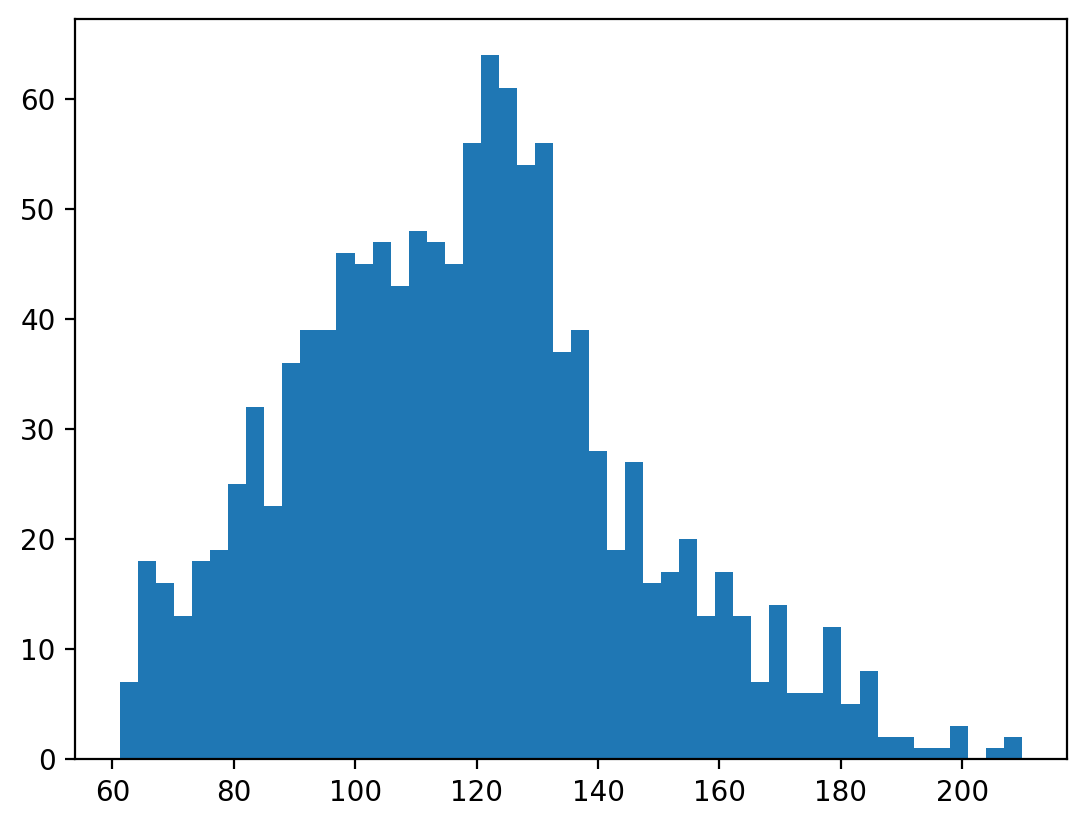

In [ ]:
plt.hist(bpms, bins=50)
plt.show()

In [ ]:
# Mean std of beat length WITHIN a song
stds = []
for filename in os.listdir(dir):
    if filename.endswith(".npy"):
        beats = np.load(os.path.join(dir, filename))
    
    beat_lengths = np.diff(beats)
    std_beat_length = np.std(beat_lengths)
    stds.append(std_beat_length)
mean_std = np.mean(stds)
print(f"Mean Std of Beat Length: {mean_std:.2f} seconds")

Mean Std of Beat Length: 0.03 seconds


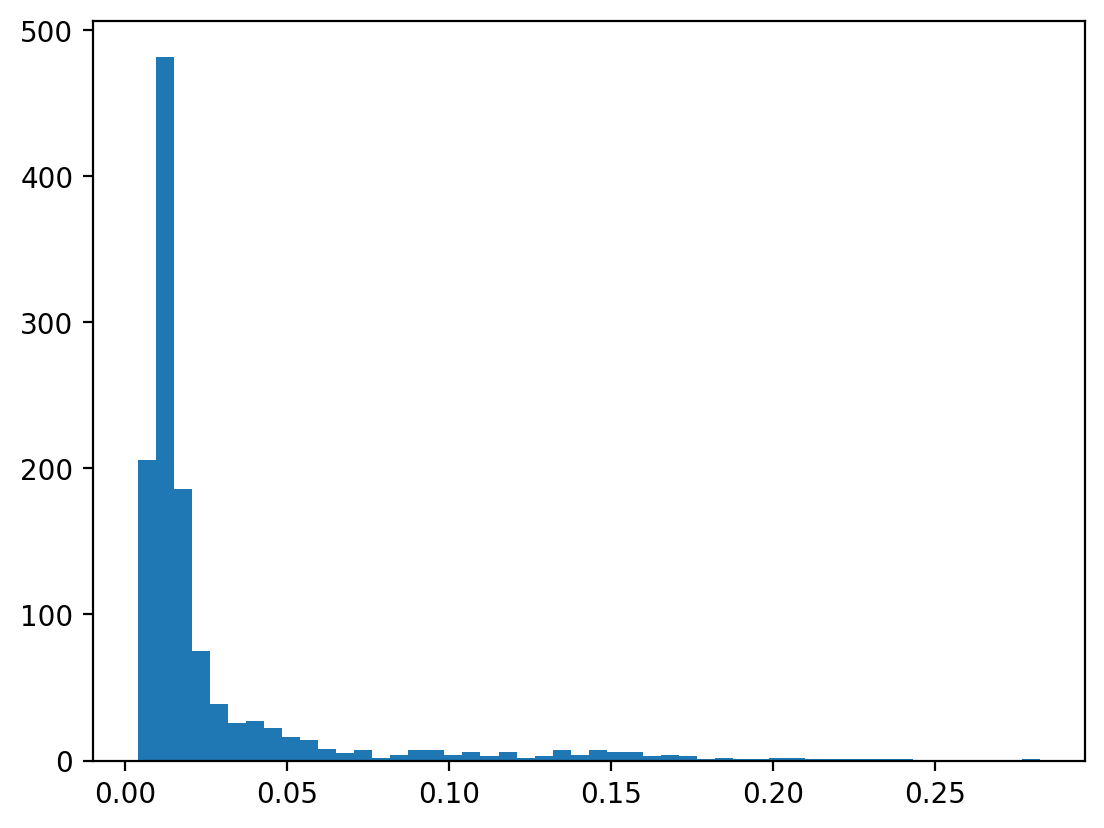

In [ ]:
plt.hist(stds, bins=50)
plt.show()

### Alignment Estimation

In [11]:
import numpy as np
from scipy.signal import correlate

def impulses_from_events(event_times, total_duration, fs=100):
    """
    Convert a list of event times into a discrete signal of impulses 
    at a given sampling rate (fs).

    Args:
        event_times (list of float): Times in seconds at which events occur.
        total_duration (float): Total duration (in seconds) to cover.
        fs (int): Sampling frequency (Hz), e.g., 100 for 0.01s resolution.

    Returns:
        np.ndarray of shape (N,): Impulse train, where N = ceil(total_duration * fs).
    """
    N = int(np.ceil(total_duration * fs))
    x = np.zeros(N, dtype=np.float32)
    for t in event_times:
        idx = int(round(t * fs))
        if 0 <= idx < N:
            x[idx] += 1
    return x

def max_corr_lag(beats, chord_boundaries, fs=100, window=1.0):
    """
    Compute cross-correlation between 'beats' and 'chord_boundaries' impulses.
    Return the lag (in seconds) at which the correlation is highest,
    restricting to +/- 1 second around 0-lag.

    Args:
        beats (list of float): Times in seconds of beat events.
        chord_boundaries (list of float): Times in seconds of chord boundary events.
        fs (int): Sampling rate for impulse trains (e.g. 100 => 0.01s resolution).

    Returns:
        float: The lag in seconds (may be positive or negative).
    """    

    max_time = 0
    max_time = max(max_time, max(beats))
    max_time = max(max_time, max(chord_boundaries))
    total_duration = max_time + 1.0  # a small margin if you want

    x_beats = impulses_from_events(beats, total_duration, fs=fs)
    y_chords = impulses_from_events(chord_boundaries, total_duration, fs=fs)

    # "full" mode => length = len(x_beats) + len(y_chords) - 1
    r_xy = correlate(x_beats, y_chords, mode='full')
    # Lags array: from -(N-1) to +(N-1)
    lags = np.arange(- (len(y_chords) - 1), len(x_beats))

    # Convert sample lags to seconds
    time_lags = lags / fs

    # Restrict to +/- 1.0 second around 0-lag
    mask = np.abs(time_lags) <= window
    restricted_r_xy = r_xy[mask]
    restricted_lags = time_lags[mask]

    # Find the lag with the maximum correlation within that window
    idx_max = np.argmax(restricted_r_xy)
    best_lag = restricted_lags[idx_max]

    return best_lag

def chord_boundaries_from_annotation(chord_annotation):
    """
    Given a chord annotation (list of Observations),
    return a sorted list of unique boundary times in seconds.
    """
    boundary_set = set()
    for obs in chord_annotation:
        start = obs.time
        end = obs.time + obs.duration
        boundary_set.add(start)
        boundary_set.add(end)
    # Convert to a sorted list
    boundaries = sorted(boundary_set)
    return boundaries

def compute_lags_for_all_files(fs=100, window=1.0):
    """
    Example loop that computes the best lag for each file in a given window around 0-lag.
    
    Args:
        all_beats_dict (dict): {filename: [list of beat times]}
        all_chords_dict (dict): {filename: [list of chord boundary times]}
        fs (int): sampling rate for impulses

    Returns:
        dict: {filename: best_lag_in_seconds} for each file.
    """
    max_lags = []
    for filename in tqdm(get_filenames()):
        ann = get_raw_chord_annotation(filename)
        chord_times = chord_boundaries_from_annotation(ann)
        beat_times = get_raw_beats(filename)
        best_lag = max_corr_lag(beat_times, chord_times, fs=fs, window=window)
        max_lags.append(best_lag)
    return max_lags


In [12]:
max_lags = compute_lags_for_all_files(fs=100, window=0.3)

100%|██████████| 1213/1213 [00:13<00:00, 88.67it/s]


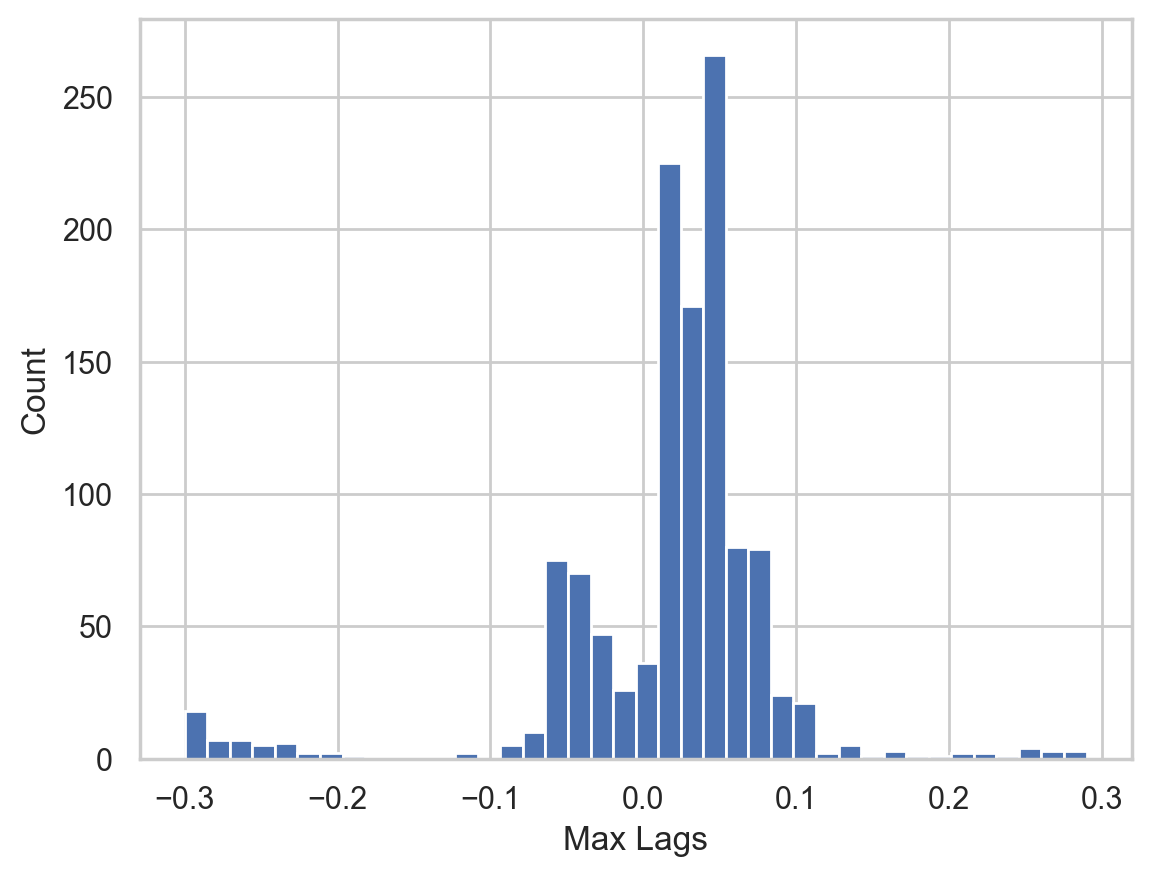

In [15]:
plt.hist(max_lags, bins=40)
plt.xlabel("Max Lags")
plt.ylabel("Count")
plt.savefig("./thesis/figures/beats_max_lags.png")
plt.show()

## What's the best you could do, only changing chords at beats?

In [19]:
import os
import numpy as np
from tqdm import tqdm
import mir_eval
from collections import defaultdict
from src.utils import get_chord_seq

def compute_oracle_predictions(ref_intervals, ref_labels, est_intervals):
    """
    For each estimated beat interval, pick the reference label
    whose interval overlaps it the most.
    
    ref_intervals:   np.array shape (R,2)
    ref_labels:      list of length R
    est_intervals:   np.array shape (E,2)
    
    returns: list of length E of predicted labels
    """
    preds = []
    for start_e, end_e in est_intervals:
        # accumulate overlap by label
        overlap = defaultdict(float)
        for (start_r, end_r), lab in zip(ref_intervals, ref_labels):
            # compute intersection
            inter = max(0.0, min(end_e, end_r) - max(start_e, start_r))
            if inter > 0:
                overlap[lab] += inter
        if overlap:
            # pick label with maximum total overlap
            best_lab = max(overlap, key=overlap.get)
        else:
            best_lab = mir_eval.chord.NO_CHORD
        preds.append(best_lab)
    return preds

def evaluate_oracle(
    dataset,
    beats_dir: str,
    evals = [
        mir_eval.chord.root,
        mir_eval.chord.thirds,
        mir_eval.chord.sevenths,
        mir_eval.chord.majmin,
        mir_eval.chord.mirex,
    ]
):
    """
    Compute the *oracle* (upper‑bound) weighted‑accuracy metrics by
    always choosing the best reference chord per estimated beat interval.
    
    dataset: your FullChordDataset
    beats_dir: where `.npy` beat files live (named to match dataset.get_filename())
    evals: list of mir_eval.chord comparison functions
    """
    song_scores = {e.__name__: [] for e in evals}
    transitions = []

    for idx in tqdm(range(len(dataset)), desc="Oracle eval"):
        # --- load detected beats ---
        fn = dataset.get_filename(idx)
        basename = os.path.splitext(os.path.basename(fn))[0]
        est_beats = np.load(os.path.join(beats_dir, f"{basename}.npy"))
        est_intervals = np.column_stack((est_beats[:-1], est_beats[1:]))

        # --- load ground‐truth chords & beats ---
        ref_labels, ref_beats = get_chord_seq(fn,
                                          override_dir=f"{dataset.input_dir}/chords")
        ref_intervals = np.column_stack((ref_beats[:-1], ref_beats[1:]))

        # --- oracle predictions ---
        pred_chords = compute_oracle_predictions(ref_intervals, ref_labels, est_intervals)

        # --- align & merge intervals as in evaluate_model ---
        adj_est_intervals, adj_labels = mir_eval.util.adjust_intervals(
            est_intervals, pred_chords,
            ref_intervals.min(), ref_intervals.max(),
            mir_eval.chord.NO_CHORD, mir_eval.chord.NO_CHORD
        )
        merged_int, mref, mest = mir_eval.util.merge_labeled_intervals(
            ref_intervals, ref_labels, adj_est_intervals, adj_labels
        )
        durs = mir_eval.util.intervals_to_durations(merged_int)

        # mask out X
        mask = np.array(mref) != "X"
        mref = np.array(mref)[mask]
        mest = np.array(mest)[mask]
        durs = np.array(durs)[mask]

        # compute weighted‐accuracy for each metric
        for cmp_fn in evals:
            comp = cmp_fn(mref, mest)
            score = mir_eval.chord.weighted_accuracy(comp, durs)
            song_scores[cmp_fn.__name__].append(score)

        # count beat‐wise transitions
        transitions.append(
            sum(1 for i in range(len(pred_chords)-1)
                if pred_chords[i] != pred_chords[i+1])
        )

    # aggregate
    results = {
        "mean_scores": {m: np.mean(song_scores[m]) for m in song_scores},
        "std_scores":  {m: np.std(song_scores[m])  for m in song_scores},
        "avg_transitions_per_song": np.mean(transitions),
    }
    return results

In [21]:
from src.utils import get_split_filenames
from src.data.dataset import FullChordDataset

_, val, _ = get_split_filenames()
dataset = FullChordDataset(val, dev_mode=True)

In [22]:
results = evaluate_oracle(
    dataset,
    beats_dir=dir,
)

Oracle eval: 100%|██████████| 241/241 [00:26<00:00,  9.02it/s]


In [23]:
results

{'mean_scores': {'root': 0.9722615439567681,
  'thirds': 0.9713628120278937,
  'sevenths': 0.9693060438056824,
  'majmin': 0.9710878704097086,
  'mirex': 0.9731402065403499},
 'std_scores': {'root': 0.024360956226633698,
  'thirds': 0.02530626829095441,
  'sevenths': 0.025842742392917797,
  'majmin': 0.025469162106142904,
  'mirex': 0.023778976441702536},
 'avg_transitions_per_song': 102.71784232365145}